In [78]:
%matplotlib notebook

import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import numpy as np
import configparser
import csv
import pandas as pd
import medpy.metric.binary as medpy

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from loss import *
from metric import *
from util import *
from train_by_cfg_STROKE import *

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"] = 'None'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='navy')
    plt.setp(bp['caps'][0], color='navy')
    plt.setp(bp['caps'][1], color='navy')
    plt.setp(bp['whiskers'][0], color='navy')
    plt.setp(bp['whiskers'][1], color='navy')
    plt.setp(bp['medians'][0], color='black')

    plt.setp(bp['boxes'][1], color='orange')
    plt.setp(bp['caps'][2], color='orange')
    plt.setp(bp['caps'][3], color='orange')
    plt.setp(bp['whiskers'][2], color='orange')
    plt.setp(bp['whiskers'][3], color='orange')
    plt.setp(bp['medians'][1], color='black')
    
    plt.setp(bp['boxes'][2], color='darkred')
    plt.setp(bp['caps'][4], color='darkred')
    plt.setp(bp['caps'][5], color='darkred')
    plt.setp(bp['whiskers'][4], color='darkred')
    plt.setp(bp['whiskers'][5], color='darkred')
    plt.setp(bp['medians'][2], color='black')

In [4]:
def setBoxColors_scheme2(bp):

    plt.setp(bp['boxes'][0], color='orange')
    plt.setp(bp['caps'][0], color='orange')
    plt.setp(bp['caps'][1], color='orange')
    plt.setp(bp['whiskers'][0], color='orange')
    plt.setp(bp['whiskers'][1], color='orange')
    plt.setp(bp['medians'][0], color='black')

    plt.setp(bp['boxes'][1], color='red')
    plt.setp(bp['caps'][2], color='red')
    plt.setp(bp['caps'][3], color='red')
    plt.setp(bp['whiskers'][2], color='red')
    plt.setp(bp['whiskers'][3], color='red')
    plt.setp(bp['medians'][1], color='black')
    
    plt.setp(bp['boxes'][2], color='maroon')
    plt.setp(bp['caps'][4], color='maroon')
    plt.setp(bp['caps'][5], color='maroon')
    plt.setp(bp['whiskers'][4], color='maroon')
    plt.setp(bp['whiskers'][5], color='maroon')
    plt.setp(bp['medians'][2], color='black')

In [5]:
def setBoxColors_scheme3(bp):

    plt.setp(bp['boxes'][0], color='lightblue')
    plt.setp(bp['caps'][0], color='lightblue')
    plt.setp(bp['caps'][1], color='lightblue')
    plt.setp(bp['whiskers'][0], color='lightblue')
    plt.setp(bp['whiskers'][1], color='lightblue')
    plt.setp(bp['medians'][0], color='black')

    plt.setp(bp['boxes'][1], color='blue')
    plt.setp(bp['caps'][2], color='blue')
    plt.setp(bp['caps'][3], color='blue')
    plt.setp(bp['whiskers'][2], color='blue')
    plt.setp(bp['whiskers'][3], color='blue')
    plt.setp(bp['medians'][1], color='black')
    
    plt.setp(bp['boxes'][2], color='navy')
    plt.setp(bp['caps'][4], color='navy')
    plt.setp(bp['caps'][5], color='navy')
    plt.setp(bp['whiskers'][4], color='navy')
    plt.setp(bp['whiskers'][5], color='navy')
    plt.setp(bp['medians'][2], color='black')

In [6]:
def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='same')

In [7]:
def compute_DSC(model, testGen):
    dsc = 0
    
    for batch in testGen:
        ims, gts = batch 
        predict = model.predict(ims)
        
        y_pred_cal = np.round(predict[:, :, :, :, 1], 0)
        y_true_cal = gts[:, :, :, :, 1]

        intersection = np.sum(y_true_cal * y_pred_cal, axis=(1,2,3))
        area_true = np.sum(y_true_cal, axis=(1,2,3))
        area_pred = np.sum(y_pred_cal, axis=(1,2,3))

        summation = area_true + area_pred 
        
        dsc += np.sum((2.0 * intersection + 1E-6) / (summation + 1E-6), axis=0)
        
    
    dsc /= (len(testGen) * len(ims))
    return dsc

In [8]:
def binned_DSC(model, testGen):
    dsc = []
    
    for batch in testGen:
        ims, gts = batch 
        predict = model.predict(ims)
        
        y_pred_cal = np.round(predict[:, :, :, :, 1], 0)
        y_true_cal = gts[:, :, :, :, 1]

        intersection = np.sum(y_true_cal * y_pred_cal, axis=(1,2,3))
        area_true = np.sum(y_true_cal, axis=(1,2,3))
        area_pred = np.sum(y_pred_cal, axis=(1,2,3))

        summation = area_true + area_pred 
        
        dsc.append(np.transpose([area_true, (2.0 * intersection + 1E-6) / (summation + 1E-6)]))
        
    return np.array(dsc).reshape(-1,2).T

## Load data, training loss, and model

In [9]:
img_path_mprage = "/scratch/mplatscher/data/DWI_data/nii_data_skull_stripped/" 
lbl_path_mprage = "/scratch/mplatscher/data/DWI_data/nii_data/stroke_gts/"

model_dir_clinical = "/scratch/mplatscher/models/UNet/500epochs_clinical/"

model_dir_christian = "/scratch/mplatscher/models/UNet/Christian/300epochs_fakeChristian/"
model_dir_clinical_christian = "/scratch/mplatscher/models/UNet/Christian/300epochs_clinical_christian2000/"

model_dir_Pix2Pix10 = "/scratch/mplatscher/models/UNet/28class_seg/300epochs_fakePix10/"
model_dir_clinical_Pix2Pix10 = "/scratch/mplatscher/models/UNet/28class_seg/300epochs_clinical_fakePix10/"

model_dir_Pix2Pix100 = "/scratch/mplatscher/models/UNet/28class_seg/300epochs_fakePix100/"
model_dir_clinical_Pix2Pix100 = "/scratch/mplatscher/models/UNet/28class_seg/300epochs_clinical_fakePix100/"

model_dir_SPADE = "/scratch/mplatscher/models/UNet/28class_seg/300epochs_fakeSPADE/"
model_dir_clinical_SPADE = "/scratch/mplatscher/models/UNet/28class_seg/300epochs_clinical_fakeSPADE/"

In [10]:
model_dir_clinical_10 = "/scratch/mplatscher/models/UNet/500epochs_clinical_10/"
model_dir_clinical_20 = "/scratch/mplatscher/models/UNet/500epochs_clinical_20/"
model_dir_clinical_50 = "/scratch/mplatscher/models/UNet/500epochs_clinical_50/"

## Training log

In [11]:
with open(model_dir_clinical + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical_hist = np.asarray(results, dtype=float).T

In [12]:
with open(model_dir_clinical_10 + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical10_hist = np.asarray(results, dtype=float).T

In [13]:
with open(model_dir_clinical_20 + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical20_hist = np.asarray(results, dtype=float).T

In [14]:
with open(model_dir_clinical_50 + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical50_hist = np.asarray(results, dtype=float).T

In [15]:
with open(model_dir_christian + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
christian_hist = np.asarray(results, dtype=float).T

In [16]:
with open(model_dir_clinical_christian + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical_christian_hist = np.asarray(results, dtype=float).T

In [17]:
with open(model_dir_Pix2Pix10 + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
pix2pix10_hist = np.asarray(results, dtype=float).T

In [18]:
with open(model_dir_clinical_Pix2Pix10 + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical_pix2pix10_hist = np.asarray(results, dtype=float).T

In [19]:
with open(model_dir_Pix2Pix100 + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
pix2pix100_hist = np.asarray(results, dtype=float).T

In [20]:
with open(model_dir_clinical_Pix2Pix100 + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical_pix2pix100_hist = np.asarray(results, dtype=float).T

In [21]:
with open(model_dir_SPADE + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
spade_hist = np.asarray(results, dtype=float).T

In [22]:
with open(model_dir_clinical_SPADE + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    
    labels, results = data[0], data[1:]
clinical_spade_hist = np.asarray(results, dtype=float).T

In [23]:
relevant = [2, 3, 5, 6]

for l in range(len(labels)):
    labels[l] = labels[l].replace('_', ' ')
    labels[l] = labels[l].replace('val', 'test set')
    labels[l] = labels[l].replace('dice coef first label', 'DSC')
    
    if 'loss' in labels[l] or 'DSC' in labels[l] and not 'epoch' in labels[l] and not 'test' in labels[l]:
        labels[l] = 'training ' +labels[l]


<IPython.core.display.Javascript object>


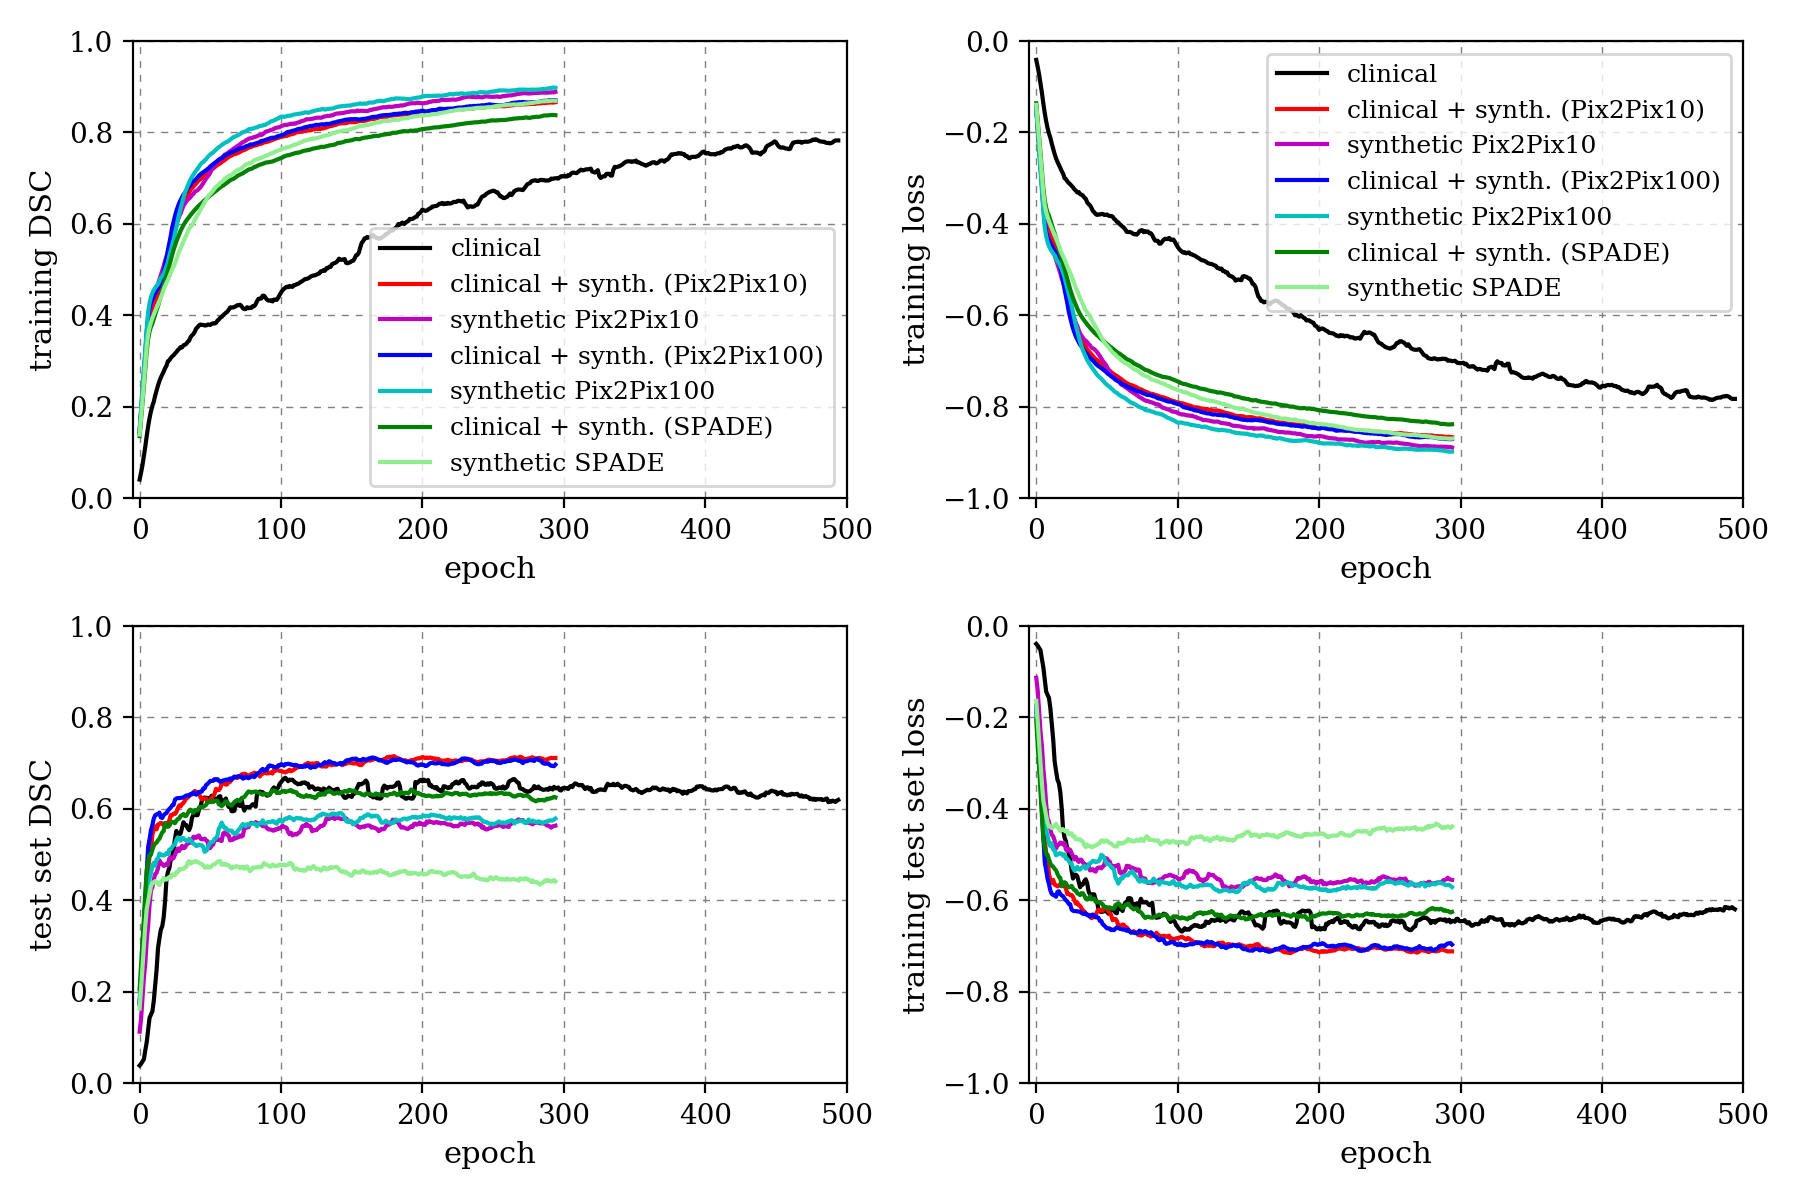

In [24]:
fig, ax = plt.subplots(2,2, figsize=(9, 6))

ax = ax.flatten()

for a, i in enumerate(relevant):
    ax[a].plot(clinical_hist[0][:-5], running_mean(clinical_hist[i], 10)[:-5], 'k', label = 'clinical')
#     ax[a].plot(clinical_newNorm_hist[0][:-5], running_mean(clinical_hist[i], 10)[:-5], 'k', label = 'clinical')
#     ax[a].plot(clinical_newNorm_noNoise_hist[0][:-5], running_mean(clinical_newNorm_noNoise_hist[i], 10)[:-5], 'g', label = 'clinical')
#     ax[a].plot(clinical_intensity_aug_hist[0][:-5], running_mean(clinical_intensity_aug_hist[i], 10)[:-5], 'b', label = 'clinical')
#     ax[a].plot(clinical_christian_hist[0][:-5], running_mean(clinical_christian_hist[i], 10)[:-5], 'k', label = 'clinical')
#     ax[a].plot(christian_hist[0][:-5], running_mean(christian_hist[i], 10)[:-5], 'k', label = 'clinical')

    

    ax[a].plot(clinical_pix2pix10_hist[0][:-5],  running_mean(clinical_pix2pix10_hist[i], 10)[:-5], 'r', label = 'clinical + synth. (Pix2Pix10)')
    ax[a].plot(pix2pix10_hist[0][:-5],  running_mean(pix2pix10_hist[i], 10)[:-5], 'm', label = 'synthetic Pix2Pix10')
#     ax[a].plot(300+pix2pix10_hist_finetuned[0][3:-5],  running_mean(pix2pix10_hist_finetuned[i], 10)[3:-5], 'm', ls='--', label = 'fine-tuned')
    

    ax[a].plot(clinical_pix2pix100_hist[0][:-5],  running_mean(clinical_pix2pix100_hist[i], 10)[:-5], 'b', label = 'clinical + synth. (Pix2Pix100)')
    ax[a].plot(pix2pix100_hist[0][:-5], running_mean(pix2pix100_hist[i], 10)[:-5], 'c', label = 'synthetic Pix2Pix100')
#     ax[a].plot(300+pix2pix100_hist_finetuned[0][3:-5],  running_mean(pix2pix100_hist_finetuned[i], 10)[3:-5], 'c', ls='--', label = 'fine-tuned')
    
    
    ax[a].plot(clinical_spade_hist[0][:-5],  running_mean(clinical_spade_hist[i], 10)[:-5], 'green', label = 'clinical + synth. (SPADE)')
    ax[a].plot(spade_hist[0][:-5],  running_mean(spade_hist[i], 10)[:-5], 'lightgreen', label = 'synthetic SPADE')
#     ax[a].plot(300+spade_hist_finetuned[0][3:-5],  running_mean(spade_hist_finetuned[i], 10)[3:-5], 'lightgreen', ls='--', label = 'fine-tuned')
    
    ax[a].set_xlabel('epoch')
    ax[a].set_ylabel(labels[i].replace('_', ' '))
    ax[a].set_xlim(-5,500)
    if 'loss' in labels[i]:
        ax[a].set_ylim(-1, 0)
    else:
        ax[a].set_ylim(0, 1)
    
    ax[a].grid(color='gray', linestyle='--', dashes=(5, 5), linewidth=.5)
    

ax[0].legend(fontsize=9, ncol=1)
ax[1].legend(fontsize=9, ncol=1)

plt.tight_layout()

# plt.savefig("convergence.png")

In [25]:
christian_models = pd.read_table("../UNet/summary2.dat")

/opt/anaconda/envs/cnn2/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


### model comparison

<IPython.core.display.Javascript object>


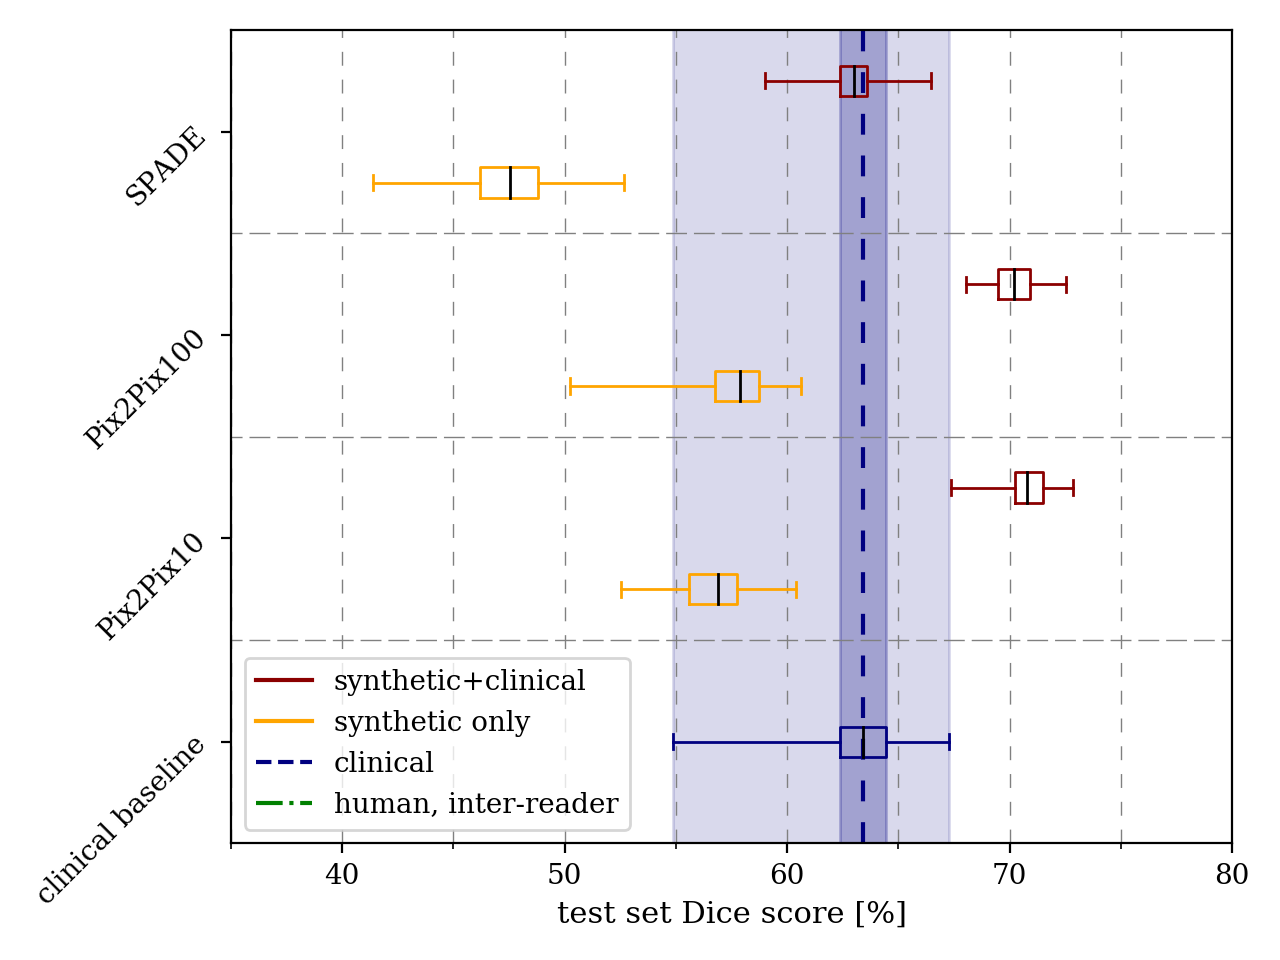

In [26]:
fig = plt.figure()
ax = plt.axes()


# first boxplot
# bp = plt.boxplot(clinical_hist[5,-200:] * 100, positions = [1], widths = 0.6, vert=False, whis='range')
# plt.setp(bp['boxes'][0], color='navy')
# plt.setp(bp['caps'][0], color='navy')
# plt.setp(bp['caps'][1], color='navy')
# plt.setp(bp['whiskers'][0], color='navy')
# plt.setp(bp['whiskers'][1], color='navy')
# plt.setp(bp['medians'][0], color='black')

#clinical baseline
A = np.array([clinical_hist[5,-100:], np.zeros_like(clinical_hist[5,-100:]), np.zeros_like(clinical_hist[5,-101:])])*100#christian_models.as_matrix()[:,-1][401:]]) * 100
bp = plt.boxplot(A, positions = [2, 1, 3], widths = 0.6, vert=False, whis='range')
setBoxColors(bp)

#shaded area
plt.plot(2*[np.median(clinical_hist[5,-100:])*100], [0,100], lw=1.5, ls='--', dashes=(5,5), c='navy')
plt.fill_between([100*np.percentile(clinical_hist[5,-100:], 25), 100*np.percentile(clinical_hist[5,-100:], 75)], [0,0],2*[100], color='navy', alpha=0.25)
plt.fill_between([100*np.min(clinical_hist[5,-100:]), 100*np.max(clinical_hist[5,-100:])], [0,0],2*[100], color='navy', alpha=0.15)


# Pix2Pix10 boxplot pair
B = np.array([np.zeros_like(clinical_pix2pix10_hist[5,-100:]), pix2pix10_hist[5,-101:], clinical_pix2pix10_hist[5,-100:]]) * 100
bp = plt.boxplot(B, positions = [5, 5, 7], widths = 0.6, vert=False, whis='range')
setBoxColors(bp)


# Pix2Pix100 boxplot pair
C = np.array([np.zeros_like(clinical_pix2pix100_hist[5,-100:]), pix2pix100_hist[5,-101:], clinical_pix2pix100_hist[5,-100:]]) * 100
bp = plt.boxplot(C, positions = [9, 9, 11], widths = 0.6, vert=False, whis='range')
setBoxColors(bp)


# SPADE boxplot pair
D = np.array([np.zeros_like(clinical_spade_hist[5,-100:]), spade_hist[5,50:151], clinical_spade_hist[5,-100:]]) * 100
bp = plt.boxplot(D, positions = [13, 13, 15], widths = 0.6, vert=False, whis='range')
setBoxColors(bp)


# #Human labelling
# plt.plot(2*[76.6], [0,100], lw=1.5, ls='-.', c='green')




plt.plot([0,100], 2*[4], 'gray', dashes=(15,5), lw=0.5)
plt.plot([0,100], 2*[8], 'gray', dashes=(15,5), lw=0.5)
plt.plot([0,100], 2*[12], 'gray', dashes=(15,5), lw=0.5)

# draw temporary red and blue lines and use them to create a legend
h1, = plt.plot([1,1], c='navy', ls='--')
h2, = plt.plot([1,1],'orange', ls='-')
h3, = plt.plot([1,1],'darkred', ls='-')
h4, = plt.plot([1,1],'green', ls='-.')

plt.legend((h3, h2, h1, h4),('synthetic+clinical', 'synthetic only', 'clinical', 'human, inter-reader'))
h1.set_visible(False)
h2.set_visible(False)
h3.set_visible(False)
h4.set_visible(False)



# set axes limits and labels
plt.xlim(35,80)
plt.ylim(0,16)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.set_yticklabels(['clinical baseline', 'Pix2Pix10', 'Pix2Pix100', 'SPADE'], rotation=45)
ax.set_yticks([2, 6, 10, 14])
plt.xlabel('test set Dice score [%]')


ax.xaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5, which='minor')
ax.xaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5, which='major')
ax.yaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5, which='minor')


plt.tight_layout()


# plt.savefig('figures/model_comparison.pdf')

plt.show()

In [225]:
"${0:1.1f} \\pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(clinical_hist[5,-100:])*100, np.sqrt(np.var(clinical_hist[5,-100:]))*100, np.max(clinical_hist[5,-100:])*100)

'$63.0 \\pm 2.0\\%; max = 67.1$'

In [27]:
"${0:1.1f} \\pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(christian_models.as_matrix()[:,-1][-100:])*100, np.sqrt(np.var(christian_models.as_matrix()[:,-1][-100:]))*100, np.max(christian_models.as_matrix()[:,-1][-100:])*100)

/opt/anaconda/envs/cnn2/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


'$70.8 \\pm 0.6\\%; max = 72.8$'

In [28]:
"${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(clinical_pix2pix10_hist[5,-100:])*100, np.sqrt(np.var(clinical_pix2pix10_hist[5,-100:]))*100, np.max(clinical_pix2pix10_hist[5,-100:])*100)

'$70.8 \\pm 1.0\\%; max = 72.8$'

In [29]:
"${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(pix2pix10_hist[5,50:150])*100, np.sqrt(np.var(pix2pix10_hist[5,50:150]))*100, np.max(pix2pix100_hist[5,50:150])*100)

'$55.7 \\pm 3.3\\%; max = 60.8$'

In [30]:
"${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(clinical_pix2pix100_hist[5,-100:])*100, np.sqrt(np.var(clinical_pix2pix100_hist[5,-100:]))*100, np.max(clinical_pix2pix100_hist[5,-100:])*100)

'$70.3 \\pm 1.1\\%; max = 72.5$'

In [31]:
"${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(pix2pix100_hist[5,50:150])*100, np.sqrt(np.var(pix2pix100_hist[5,50:150]))*100, np.max(pix2pix100_hist[5,50:150])*100)

'$57.1 \\pm 2.7\\%; max = 60.8$'

In [32]:
"${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(clinical_spade_hist[5,-100:])*100, np.sqrt(np.var(clinical_spade_hist[5,-100:]))*100, np.max(clinical_spade_hist[5,-100:])*100)

'$62.9 \\pm 1.2\\%; max = 66.4$'

In [33]:
print("${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(spade_hist[5,50:150])*100, np.sqrt(np.var(spade_hist[5,50:150]))*100, np.max(spade_hist[5,50:150])*100))

$47.3 \pm 2.2\%; max = 52.7$


### model fine tuning

In [34]:
num = (10, 20, 50)

In [35]:
results=[]
for n in num:
    with open(model_dir_Pix2Pix10 + "FINE_TUNING_ON_" + str(n) +  "_SAMPLES_150_EPOCHS/logs/historyLog.csv", newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        results.append(data[1:])

pix2pix10_hist_finetuned = np.asarray(results, dtype=float)[...,5]

In [36]:
results=[]
for n in num:
    with open(model_dir_Pix2Pix100 + "FINE_TUNING_ON_" + str(n) +  "_SAMPLES_150_EPOCHS/logs/historyLog.csv", newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        results.append(data[1:])

pix2pix100_hist_finetuned = np.asarray(results, dtype=float)[...,5]

In [37]:
results=[]
for n in num:
    with open(model_dir_SPADE + "FINE_TUNING_ON_" + str(n) +  "_SAMPLES_150_EPOCHS/logs/historyLog.csv", newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        results.append(data[1:])

spade_hist_finetuned = np.asarray(results, dtype=float)[...,5]

<IPython.core.display.Javascript object>


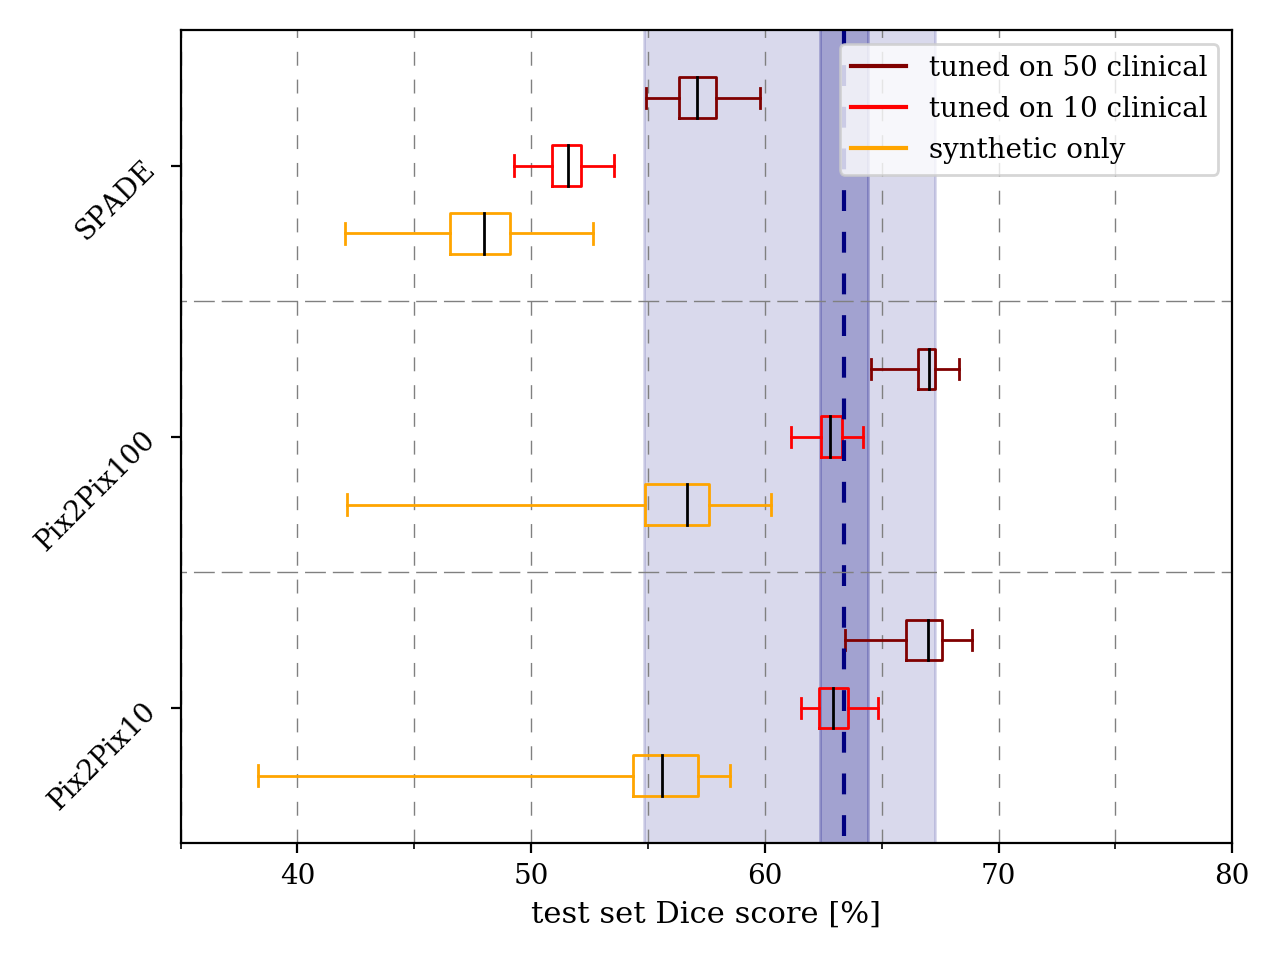

In [38]:
fig = plt.figure()
ax = plt.axes()

# Clinical
A = np.array([clinical10_hist[5,-100:], clinical50_hist[5,-101:], clinical_hist[5,-100:]]) * 100
bp = plt.boxplot(A, positions = [-3, -2, -1], widths = 0.6, vert=False, whis='range')
setBoxColors_scheme3(bp)


# Pix2Pix10 boxplot pair
B = np.array([pix2pix10_hist[5,50:101], pix2pix10_hist_finetuned[0,50:100], pix2pix10_hist_finetuned[-1,50:100]]) * 100
bp = plt.boxplot(B, positions = [1, 2, 3], widths = 0.6, vert=False, whis='range')
setBoxColors_scheme2(bp)


# Pix2Pix100 boxplot pair
C = np.array([pix2pix100_hist[5,50:101], pix2pix100_hist_finetuned[0,50:100], pix2pix100_hist_finetuned[-1,50:100]]) * 100
bp = plt.boxplot(C, positions = [5, 6, 7], widths = 0.6, vert=False, whis='range')
setBoxColors_scheme2(bp)


# SPADE boxplot pair
D = np.array([spade_hist[5,50:101], spade_hist_finetuned[0,50:100], spade_hist_finetuned[-1,50:100]]) * 100
bp = plt.boxplot(D, positions = [9, 10, 11], widths = 0.6, vert=False, whis='range')
setBoxColors_scheme2(bp)



plt.plot(2*[np.median(clinical_hist[5,-100:])*100], [-10,100], lw=1.5, ls='--', dashes=(5,5), c='navy')
plt.fill_between([100*np.percentile(clinical_hist[5,-100:], 25), 100*np.percentile(clinical_hist[5,-100:], 75)], 2*[-10],2*[100], color='navy', alpha=0.25)
plt.fill_between([100*np.min(clinical_hist[5,-100:]), 100*np.max(clinical_hist[5,-100:])], 2*[-10], 2*[100], color='navy', alpha=0.15)

plt.plot([0,100], 2*[0], 'gray', dashes=(15,5), lw=0.5)
plt.plot([0,100], 2*[4], 'gray', dashes=(15,5), lw=0.5)
plt.plot([0,100], 2*[8], 'gray', dashes=(15,5), lw=0.5)


# draw temporary red and blue lines and use them to create a legend
h6, = plt.plot([1,1], 'lightblue', ls='-')
h5, = plt.plot([1,1], 'blue', ls='-')
h4, = plt.plot([1,1], 'navy', ls='-')
h3, = plt.plot([1,1], c='orange', ls='-')
h2, = plt.plot([1,1],'red', ls='-')
h1, = plt.plot([1,1],'maroon', ls='-')

plt.legend((h1, h2, h3, h4, h5, h6), 
#            ('tuned on 50 clinical', 'tuned on 10 clinical', 'synthetic only', 'all clinical', '50 clinical', '10 clinical'),
           ('tuned on 50 clinical', 'tuned on 10 clinical', 'synthetic only'),
           loc=1)

h1.set_visible(False)
h2.set_visible(False)
h3.set_visible(False)
h4.set_visible(False)
h5.set_visible(False)
h6.set_visible(False)



# set axes limits and labels
plt.xlim(35,80)
plt.ylim(0,12)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(5))
# ax.set_yticklabels(['clinical baseline', 'Pix2Pix100', 'SPADE'], rotation=45)
# ax.set_yticks([-2, 2, 6, 10])
ax.set_yticklabels(['Pix2Pix10', 'Pix2Pix100', 'SPADE'], rotation=45)
ax.set_yticks([2, 6, 10])
plt.xlabel('test set Dice score [%]')


ax.xaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5, which='minor')
ax.xaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5, which='major')
ax.yaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5, which='minor')


plt.tight_layout()


plt.savefig('figures/model_tuning.pdf')

plt.show()

In [39]:
print("${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(pix2pix10_hist_finetuned[0,50:150])*100, np.sqrt(np.var(pix2pix10_hist_finetuned[0,50:150]))*100, np.max(pix2pix10_hist_finetuned[0,50:150])*100))

$62.9 \pm 0.8\%; max = 64.8$


In [48]:
print("${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(pix2pix10_hist_finetuned[-1,50:150])*100, np.sqrt(np.var(pix2pix10_hist_finetuned[-1,50:150]))*100, np.max(pix2pix10_hist_finetuned[-1,50:150])*100))

$66.4 \pm 1.1\%; max = 68.9$


In [40]:
print("${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(pix2pix100_hist_finetuned[0,50:150])*100, np.sqrt(np.var(pix2pix100_hist_finetuned[0,50:150]))*100, np.max(pix2pix100_hist_finetuned[0,50:150])*100))

$62.3 \pm 0.9\%; max = 64.2$


In [41]:
print("${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(pix2pix100_hist_finetuned[-1,50:150])*100, np.sqrt(np.var(pix2pix100_hist_finetuned[-1,50:150]))*100, np.max(pix2pix100_hist_finetuned[-1,50:150])*100))

$66.8 \pm 0.7\%; max = 68.3$


In [42]:
print("${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(spade_hist_finetuned[0,50:150])*100, np.sqrt(np.var(spade_hist_finetuned[0,50:150]))*100, np.max(spade_hist_finetuned[0,50:150])*100))

$51.0 \pm 1.2\%; max = 53.6$


In [43]:
print("${0:1.1f} \pm {1:1.1f}\%; max = {2:1.1f}$".format(np.mean(spade_hist_finetuned[-1,50:150])*100, np.sqrt(np.var(spade_hist_finetuned[-1,50:150]))*100, np.max(spade_hist_finetuned[-1,50:150])*100))

$56.4 \pm 1.5\%; max = 59.8$


In [44]:
[np.mean(pix2pix100_hist_finetuned[0,50:100]), np.mean(pix2pix100_hist_finetuned[-1,50:100])] / np.mean(clinical10_hist[5, -100:])

array([21.92512799, 23.35444003])

In [45]:
[np.mean(pix2pix10_hist_finetuned[0,50:100]), np.mean(pix2pix10_hist_finetuned[-1,50:100])] / np.mean(clinical10_hist[5, -100:])

array([21.96854802, 23.3313482 ])

In [46]:
[np.mean(spade_hist_finetuned[0,50:100]), np.mean(spade_hist_finetuned[-1,50:100])] / np.mean(clinical10_hist[5, -100:])

array([17.98220388, 19.96528609])

In [47]:
np.mean(clinical50_hist[5, -100:])

0.1255031006060093

## Visual evaluation on test set

In [90]:
def dice(y_true, y_pred):
    """
    Dice score. Only for batch size 1!
    """
    Y_pred = K.argmax(y_pred, axis=-1).numpy().squeeze()
    Y_true = y_true[0,...,1]
    res = medpy.dc(Y_pred, Y_true)
    return res

In [97]:
def recall(y_true, y_pred):
    """
    Precision Loss. Only for batch size 1!
    """
    Y_pred = K.argmax(y_pred, axis=-1).numpy().squeeze()
    Y_true = y_true[0,...,1]
    
    res = medpy.recall(Y_pred, Y_true)

    return res

In [107]:
def assd(y_true, y_pred):
    """
    Average symmetyric surface distance (ASSD) Loss. Only for batch size 1!
    """
    Y_pred = K.argmax(y_pred, axis=-1).numpy().squeeze()
    Y_true = y_true[0,...,1]
    try:
        res = medpy.assd(Y_pred, Y_true, voxelspacing=[2., 2., 3.6])
    except:
        res = 0.
    return res

### load a model

In [123]:
model_dir_clinical = "/scratch/mplatscher/models/UNet/STROKE_SEG_CLINICAL_val/"
model_dir_clinical_Pix2Pix10 = "/scratch/mplatscher/models/UNet/STROKE_SEG_CLINICAL_1.0_PIX100_1.0_normalDB_val/"
model_dir_clinical_Pix2Pix100 = "/scratch/mplatscher/models/UNet/20210114_120951_DropoutFalse_STROKE_SEG_CLINICAL_PIX100_val/"
model_dir_clinical_SPADE = "/scratch/mplatscher/models/UNet/20210114_120730_DropoutFalse_STROKE_SEG_CLINICAL_SPADE_val/"

In [124]:
# Load config file.
p = configparser.ConfigParser()
p.optionxform = str
p.read('settings/settingsSTROKE_clinical.cfg')#model_dir_clinical + "settingsSTROKE_clinical.cfg")

# Collect main, data generation, normalization, image, augmentation and callback settings.
mp         = collect_parameters(p, 'MAIN')
gen_param  = collect_parameters(p, 'GEN')
norm_param = collect_parameters(p, 'NORM')
aug_param  = collect_parameters(p, 'AUG')
cb_param   = collect_parameters(p, 'CALLBACK')

misc_param = assemble_additional_parameters(mp, gen_param)

In [125]:
custom_objects = {'dice_coef_first_label':dice_coef_first_label}

In [126]:
test_ims_path = "/scratch/mplatscher/data/DWI_data/testdata_nii/ims"
test_gts_path = "/scratch/mplatscher/data/DWI_data/testdata_nii/gts"

In [127]:
test_ims = []
test_gts = []
for im in os.listdir(test_ims_path):
    try:
        test_ims.append(nib.load(test_ims_path + '/' + im).get_fdata())
        test_gts.append(nib.load(test_ims_path.replace('ims', 'gts') + '/' + im).get_fdata().squeeze())
    except:
        pass
test_ims = np.asarray(test_ims, dtype=int)[..., 4:36, np.newaxis]
test_gts = to_categorical(np.asarray(test_gts, dtype=int)[..., 4:36, np.newaxis], 2)

In [128]:
test_ids = generatePartitionTrainAndValidFromFolderRandomly(test_ims_path, 0, labelPathFolder=test_gts_path, shuffle_train_val=False, threshold = 20, image_type='.nii.gz',label_type='.nii.gz')["train"]

misc_param["imageType"] = ".nii.gz"
misc_param["labelType"] = ".nii.gz"
# misc_param['variableTypeX'] = np.float64
# misc_param['variableTypeY'] = np.int8
misc_param["batch_size"] = 1
misc_param["shuffletrain"] = False
aug_param["maxNumberOfTransformation"] = 0

#new image normalization [0.0, 1.0]
testGen = DataGenerator(test_ids, test_ims_path, test_gts_path, norm_param, 1, aug_param, **misc_param)

; 0.0 augmentations performed on average


<IPython.core.display.Javascript object>


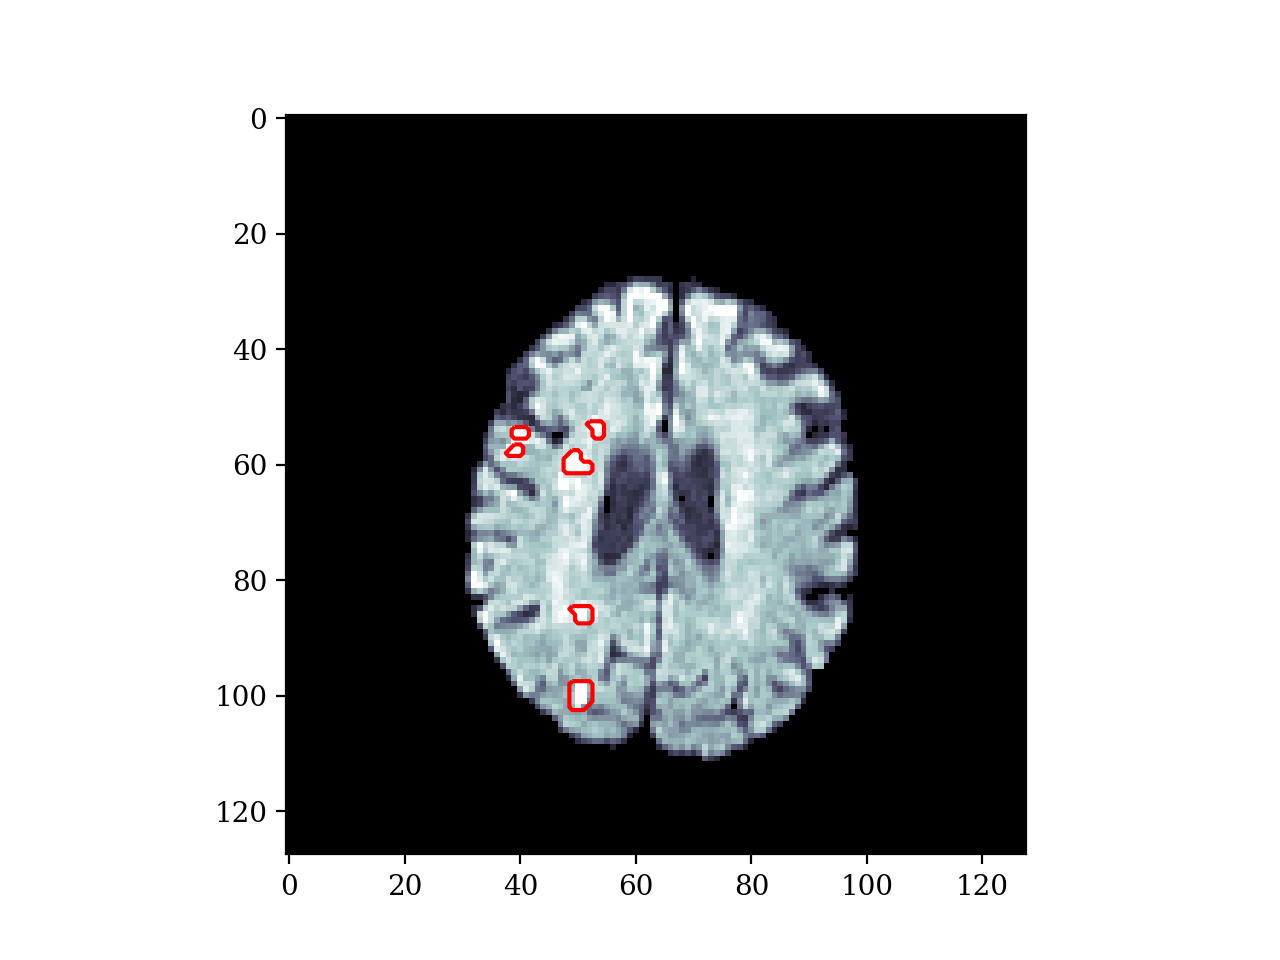

In [129]:
plt.figure()

# X, Y = testGen[0]
plt.imshow(X[0,:,::-1,18,0].T, cmap='bone')
plt.contour(Y[0,:,::-1,18,1].T, levels=[0.5], colors=['r'])

plt.show()

In [68]:
clinical_model = load_model(model_dir_clinical + 'model.h5', custom_objects = custom_objects, compile=False)

fakePix10_model = load_model(model_dir_Pix2Pix10 + 'model.h5', custom_objects = custom_objects, compile=False)
clinical_fakePix10_model = load_model(model_dir_clinical_Pix2Pix10 + 'model.h5', custom_objects = custom_objects, compile=False)

fakePix100_model = load_model(model_dir_Pix2Pix100 + 'model.h5', custom_objects = custom_objects, compile=False)
clinical_fakePix100_model = load_model(model_dir_clinical_Pix2Pix100 + 'model_-0.86_145.h5', custom_objects = custom_objects, compile=False)

fakeSPADE_model = load_model(model_dir_SPADE + 'model.h5', custom_objects = custom_objects, compile=False)
clinical_fakeSPADE_model = load_model(model_dir_clinical_SPADE + 'model_-0.75_73.h5', custom_objects = custom_objects, compile=False)

### Run predictions

In [155]:
im, gts = testGen[5]

In [156]:
predict = clinical_model.predict(im)

predict_clinical_pix10 = clinical_fakePix10_model.predict(im)
predict_pix10 = fakePix10_model.predict(im)

predict_clinical_pix100 = clinical_fakePix100_model.predict(im)
predict_pix100 = fakePix100_model.predict(im)

predict_clinical_SPADE = clinical_fakeSPADE_model.predict(im)
predict_SPADE = fakeSPADE_model.predict(im)



<IPython.core.display.Javascript object>


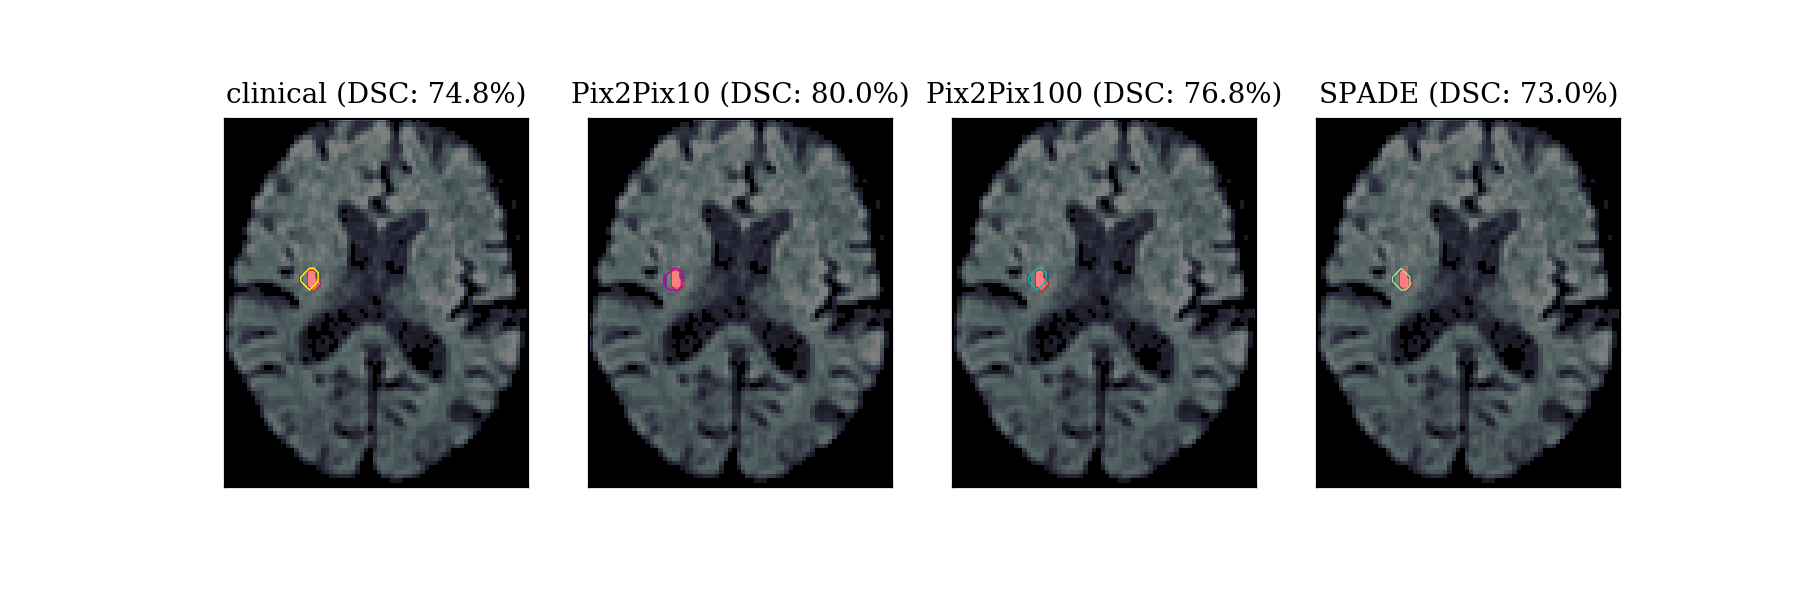

/opt/anaconda/envs/cnn2/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/opt/anaconda/envs/cnn2/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()
/opt/anaconda/envs/cnn2/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/opt/anaconda/envs/cnn2/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


In [163]:
fig, ax = plt.subplots(1,4, figsize=(9,3))


i=0
slc = 15

#Ground truth and image
for a in ax:
    a.imshow(im[i,30:100,15:100,slc,0].T[::-1,], cmap='bone')
    a.contourf(np.argmax(gts[i,30:100,15:100,slc], axis=-1).T[::-1,], levels=[0,.5, 1.5], colors=['none', 'r'], alpha=0.5)

#clinical
ax[0].contour(np.argmax(predict, axis=-1)[i, 30:100,15:100,slc].T[::-1,], levels=[1], colors=['yellow'], linewidths=[.5])

# #Pix2Pix10
ax[1].contour(np.argmax(predict_clinical_pix10, axis=-1)[i, 30:100,15:100,slc].T[::-1,], levels=[1], colors=['m'], linewidths=[.5])
# ax[1].contour(np.argmax(predict_pix10[i, 30:100,15:100,slc].T[::-1,], levels=[1], colors=['m'], linewidths=[.5])

# #Pix2Pix100
ax[2].contour(np.argmax(predict_clinical_pix100, axis=-1)[i, 30:100,15:100,slc].T[::-1,], levels=[1], colors=['c'], linewidths=[.5])
# ax[2].contour(np.argmax(predict_pix100[i, 30:100,15:100,slc].T[::-1,], levels=[1], colors=['c'], linewidths=[.5])

# #SPADE
ax[3].contour(np.argmax(predict_clinical_SPADE, axis=-1)[i, 30:100,15:100,slc].T[::-1,], levels=[1], colors=['lightgreen'], linewidths=[.5])
# ax[3].contour(np.argmax(predict_SPADE[i, 30:100,15:100,slc].T[::-1,], levels=[1], colors=['lightgreen'], linewidths=[.5])


ax[0].set_title("clinical (DSC: {0:1.1f}%)".format(100*dice(gts, predict)))
ax[1].set_title("Pix2Pix10 (DSC: {0:1.1f}%)".format(100*dice(gts, predict_clinical_pix10)))
ax[2].set_title("Pix2Pix100 (DSC: {0:1.1f}%)".format(100*dice(gts, predict_clinical_pix100)))
ax[3].set_title("SPADE (DSC: {0:1.1f}%)".format(100*dice(gts, predict_clinical_SPADE)))




for a in ax:
    a.set_xticks([], [])
    a.set_yticks([], [])

    
plt.show()
# plt.savefig('example_big2.png')

In [137]:
X = simpleNormalization(test_ims[:10])

X = (X + 1.) / 2 

In [272]:
clinical_model.evaluate(x=X, y=test_gts[:10])

1/1 [==============================] - 0s 1ms/step - loss: 0.1566


0.15658007562160492

In [273]:
clinical_model.compile(loss=dice_coef_first_label)

In [271]:
clinical_model.evaluate(testGen)

71/71 [==============================] - 23s 321ms/step - loss: 0.6300


0.6300004124641418

## Compute Dice score on non-thresholded test data

In [91]:
thresh=-1
test_ids_Thresh = generatePartitionTrainAndValidFromFolderRandomly(test_ims_path, 1, labelPathFolder=test_gts_path, shuffle_train_val=False, threshold = thresh, image_type='.nii.gz')["validation"]
testGen_Thresh = DataGenerator(test_ids_Thresh, test_ims_path, test_gts_path, norm_param, 0, {}, **misc_param)

len(test_ids_Thresh)

85

In [90]:
test_ids_noThresh = generatePartitionTrainAndValidFromFolderRandomly(test_ims_path, 1, labelPathFolder=test_gts_path, shuffle_train_val=False, threshold = 0, image_type='.nii.gz')["validation"]
testGen_noThresh = DataGenerator(test_ids_noThresh, test_ims_path, test_gts_path, norm_param, 0, {}, **misc_param)

len(test_ids_noThresh)

159

In [96]:
1968 - 2027

-59

In [51]:
clinical = binned_DSC(clinical_model, testGen_Thresh)

clinical_pix10 = binned_DSC(clinical_fakePix10_model, testGen_Thresh)
clinical_pix100 = binned_DSC(clinical_fakePix100_model, testGen_Thresh)
clinical_spade = binned_DSC(clinical_fakeSPADE_model, testGen_Thresh)

pix10 = binned_DSC(fakePix10_model, testGen_Thresh)
pix100 = binned_DSC(fakePix100_model, testGen_Thresh)
spade = binned_DSC(fakeSPADE_model, testGen_Thresh)

<IPython.core.display.Javascript object>


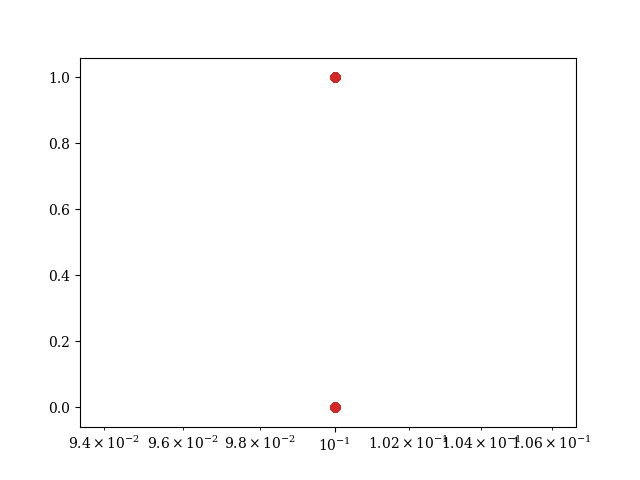

In [52]:
plt.figure()

plt.scatter(clinical[0] + .1, clinical[1])
plt.scatter(pix10[0] + .1, clinical_pix10[1])
plt.scatter(pix100[0] + .1, clinical_pix100[1])
plt.scatter(spade[0] + .1, clinical_spade[1])

plt.xscale('log')

In [59]:
len(np.argwhere(clinical[1] > .5))

38

In [66]:
len(np.argwhere(pix100[1] > .5))

12

In [67]:
len(np.argwhere(spade[1] > .5))

24

In [122]:
compute_DSC(clinical_model, testGen_Thresh), compute_DSC(clinical_model, testGen_noThresh)

(0.4470589980088542, 0.5605765077375596)

In [123]:
compute_DSC(fakePix10_model, testGen_Thresh), compute_DSC(fakePix10_model, testGen_noThresh)

(0.10588251966446478, 0.34291097887100713)

In [124]:
compute_DSC(clinical_fakePix10_model, testGen_Thresh), compute_DSC(clinical_fakePix10_model, testGen_noThresh)

(0.43137267617618336, 0.5783610332396723)

In [125]:
compute_DSC(fakePix100_model, testGen_Thresh), compute_DSC(fakePix100_model, testGen_noThresh)

(0.20000017370238618, 0.35005409045854924)

In [126]:
compute_DSC(clinical_fakePix100_model, testGen_Thresh), compute_DSC(clinical_fakePix100_model, testGen_noThresh)

(0.7529412550084731, 0.6366388659323415)

In [127]:
compute_DSC(fakeSPADE_model, testGen_Thresh), compute_DSC(fakeSPADE_model, testGen_noThresh)

(0.38823537433867394, 0.4196046824760478)

In [128]:
compute_DSC(clinical_fakeSPADE_model, testGen_Thresh), compute_DSC(clinical_fakeSPADE_model, testGen_noThresh)

(0.7882353642407586, 0.6796512080777076)

## Evaluate false positive & false negative rate

In [46]:
def compute_metric(model, testGen):
    FN, FP = 0, 0
    GTS = 0
    
    for batch in testGen:
        ims, gts = batch 
        predict = np.argmax(model.predict(ims), axis=-1)
        
        FN += len(np.argwhere(predict - np.argmax(gts, axis=-1) < 0 )) 
        FP += len(np.argwhere(predict - np.argmax(gts, axis=-1) > 0 )) 
        GTS += np.sum(np.argmax(gts, axis=-1))
        
    return FP/GTS, FN/GTS

In [47]:
compute_metric(clinical_model, testGen)

(0.09694106623460284, 0.2588869151033635)

In [48]:
compute_metric(clinical_fakePix10_model, testGen)

(0.07912819411638394, 0.24287973139164892)

In [49]:
compute_metric(fakePix10_model, testGen)

(0.020038261073262148, 0.7325238643683994)

In [50]:
compute_metric(clinical_fakePix100_model, testGen)

(0.0710172370039237, 0.28414703183867884)

In [51]:
compute_metric(fakePix100_model, testGen)

(0.037587600288910145, 0.6875085404181389)

In [52]:
compute_metric(clinical_fakeSPADE_model, testGen)

(0.09283190505007125, 0.2318894333066547)

In [53]:
compute_metric(fakeSPADE_model, testGen)

(0.03845628281960685, 0.6679583032385266)

## Experiments with various fake databases + intensity augmentations (Pix2Pix100)

In [109]:
model_dir_Pix2Pix100_ref = "/scratch/mplatscher/models/UNet/synthetic_from_strokeDB/300epochs_fakePix100_normalDB_ref/"
model_dir_Pix2Pix100_ref_intensityDA = "/scratch/mplatscher/models/UNet/synthetic_from_strokeDB/300epochs_fakePix100_normalDB_ref_aug/"
model_dir_Pix2Pix100_strokeDB = "/scratch/mplatscher/models/UNet/synthetic_from_strokeDB/300epochs_fakePix100_strokeDB/"

model_dir_Pix2Pix100 = "/scratch/mplatscher/models/UNet/synthetic_from_strokeDB/300epochs_fakePix100_normalDB_intAug/"#"/scratch/mplatscher/models/UNet/28class_seg/300epochs_fakePix100/"
model_dir_Pix2Pix100_intensityDA = "/scratch/mplatscher/models/UNet/synthetic_from_strokeDB/300epochs_fakePix100_normalDB_aug/"
model_dir_Pix2Pix100_strokeDBx4 = "/scratch/mplatscher/models/UNet/synthetic_from_strokeDB/300epochs_fakePix100_strokeDB_1712/"

In [119]:
with open(model_dir_Pix2Pix100_ref + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
pix2pix100ref_hist = np.asarray(results, dtype=float).T

In [120]:
with open(model_dir_Pix2Pix100_ref_intensityDA + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
pix2pix100refDA_hist = np.asarray(results, dtype=float).T

In [121]:
with open(model_dir_Pix2Pix100_strokeDB + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
pix2pix100strokeDB_hist = np.asarray(results, dtype=float).T

In [122]:
with open(model_dir_Pix2Pix100 + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
pix2pix100intAug_hist = np.asarray(results, dtype=float).T

In [123]:
with open(model_dir_Pix2Pix100_intensityDA + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
pix2pix100DA_hist = np.asarray(results, dtype=float).T

In [124]:
with open(model_dir_Pix2Pix100_strokeDBx4 + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
pix2pix100strokeDBx4_hist = np.asarray(results, dtype=float).T

<IPython.core.display.Javascript object>


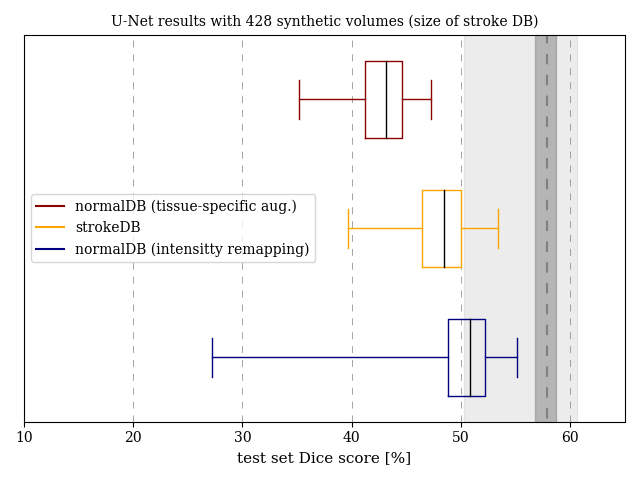

In [125]:
fig = plt.figure()
ax = plt.axes()



# Pix2Pix100 boxplot pair
C = np.array([pix2pix100ref_hist[5,-100:], pix2pix100strokeDB_hist[5,-101:], pix2pix100refDA_hist[5,-50:]]) * 100
bp = plt.boxplot(C, positions = [0, 1, 2], widths = 0.6, vert=False, whis='range')
setBoxColors(bp)

#
plt.plot(2*[np.median(pix2pix100_hist[5,-100:])*100], [-1,3], c='gray', ls='--', dashes=(5,5))
plt.fill_between([np.percentile(pix2pix100_hist[5,-100:],25)*100, np.percentile(pix2pix100_hist[5,-100:],75)*100], [-1,-1],2*[3], color='gray', alpha=0.5)
plt.fill_between([np.min(pix2pix100_hist[5,-100:])*100, np.max(pix2pix100_hist[5,-100:])*100], [-1,-1], [3,3], color='gray', alpha=0.15)


# draw temporary red and blue lines and use them to create a legend
h1, = plt.plot([1,1], c='navy', ls='-')
h2, = plt.plot([1,1],'orange', ls='-')
h3, = plt.plot([1,1],'darkred', ls='-')

plt.legend((h3, h2, h1),('normalDB (tissue-specific aug.)', 'strokeDB', 'normalDB (intensitty remapping)'), loc='center left')
h1.set_visible(False)
h2.set_visible(False)
h3.set_visible(False)

plt.xlim(10,65)
plt.ylim(-.5,2.5)

ax.set_yticks([])
plt.xlabel('test set Dice score [%]')


plt.title(r"U-Net results with 428 synthetic volumes (size of stroke DB)")

ax.xaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5, which='minor')
ax.xaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5 , which='major')
ax.yaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5, which='minor')

plt.tight_layout()

plt.savefig("figures/pix100_strokeDB.png")

<IPython.core.display.Javascript object>


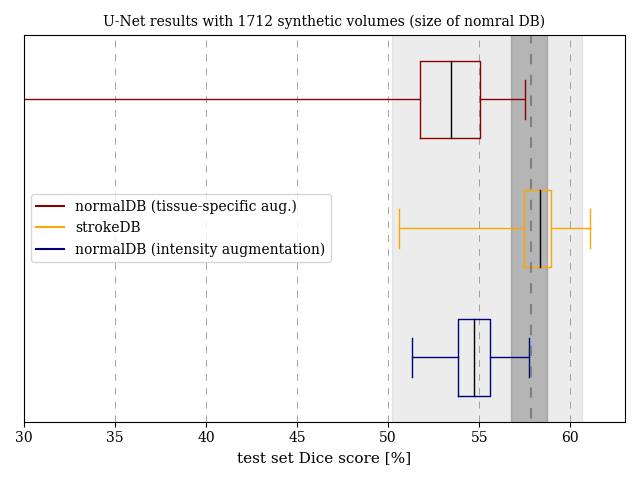

In [126]:
fig = plt.figure()
ax = plt.axes()



# Pix2Pix100 boxplot pair
C = np.array([pix2pix100intAug_hist[5,-100:], pix2pix100strokeDBx4_hist[5,-101:], pix2pix100DA_hist[5,-100:]]) * 100
bp = plt.boxplot(C, positions = [0, 1, 2], widths = 0.6, vert=False, whis='range')
setBoxColors(bp)

#
plt.plot(2*[np.median(pix2pix100_hist[5,-100:])*100], [-1,3], c='gray', ls='--', dashes=(5,5))
plt.fill_between([np.percentile(pix2pix100_hist[5,-100:],25)*100, np.percentile(pix2pix100_hist[5,-100:],75)*100], [-1,-1],2*[3], color='gray', alpha=0.5)
plt.fill_between([np.min(pix2pix100_hist[5,-100:])*100, np.max(pix2pix100_hist[5,-100:])*100], [-1,-1], [3,3], color='gray', alpha=0.15)


# draw temporary red and blue lines and use them to create a legend
h1, = plt.plot([1,1], c='navy', ls='-')
h2, = plt.plot([1,1],'orange', ls='-')
h3, = plt.plot([1,1],'darkred', ls='-')

plt.legend((h3, h2, h1),('normalDB (tissue-specific aug.)', 'strokeDB', 'normalDB (intensity augmentation)'), loc='center left')
h1.set_visible(False)
h2.set_visible(False)
h3.set_visible(False)

plt.xlim(30,63)
plt.ylim(-.5,2.5)

ax.set_yticks([])
plt.xlabel('test set Dice score [%]')


plt.title(r"U-Net results with 1712 synthetic volumes (size of nomral DB)")

ax.xaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5, which='minor')
ax.xaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5 , which='major')
ax.yaxis.grid(color='gray', linestyle='--', dashes=(10, 10), linewidth=.5, which='minor')

plt.tight_layout()

plt.savefig("figures/pix100_strokeDB1712.png")

## Normalization experiments

In [127]:

model_dir_clinical_newNorm = "/scratch/mplatscher/models/UNet/GAN_norm/20201116_162219_DropoutFalse_STROKE_SEG_CLINICAL_newnorm/"
model_dir_clinical_newNorm_noNoise = "/scratch/mplatscher/models/UNet/GAN_norm/20201119_084008_DropoutFalse_STROKE_SEG_CLINICAL_newnorm_noNoise/"
model_dir_clinical_intensity_aug = "/scratch/mplatscher/models/UNet/GAN_norm/20201119_084131_DropoutFalse_STROKE_SEG_CLINICAL_intensityNorm/"
model_dir_clinical_tailUNet = "/scratch/mplatscher/models/UNet/GAN_norm/20201116_185219_DropoutFalse_STROKE_SEG_CLINICAL_tailUNet/"

In [128]:
with open(model_dir_clinical_newNorm + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical_newNorm_hist = np.asarray(results, dtype=float).T

In [129]:
with open(model_dir_clinical_newNorm_noNoise + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical_newNorm_noNoise_hist = np.asarray(results, dtype=float).T

In [130]:
with open(model_dir_clinical_intensity_aug + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical_intensity_aug_hist = np.asarray(results, dtype=float).T

In [131]:
with open(model_dir_clinical_tailUNet + "logs/historyLog.csv", newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
    labels, results = data[0], data[1:]
clinical_tailUNet_hist = np.asarray(results, dtype=float).T

<IPython.core.display.Javascript object>


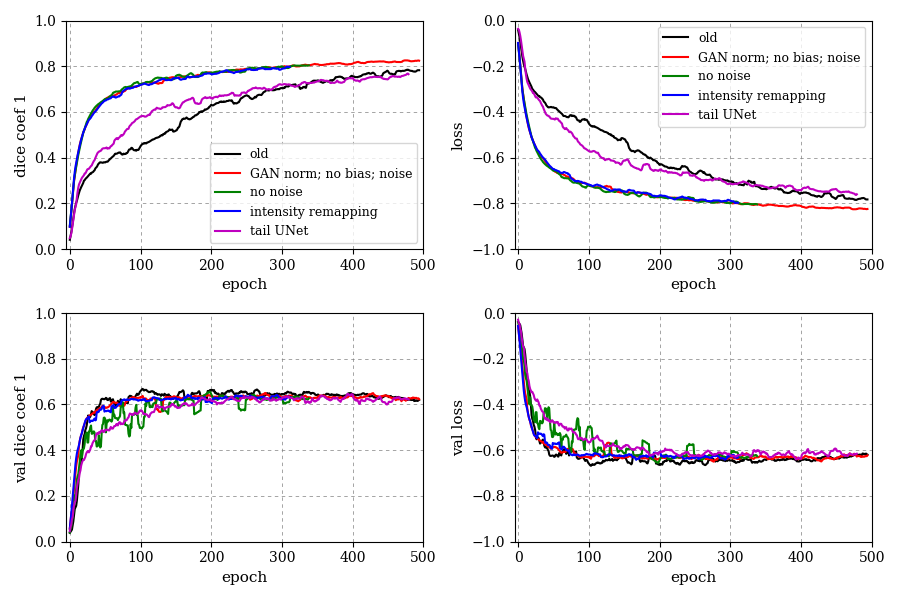

In [132]:
fig, ax = plt.subplots(2,2, figsize=(9, 6))

ax = ax.flatten()

for a, i in enumerate(relevant):
    ax[a].plot(clinical_hist[0][:-5], running_mean(clinical_hist[i], 10)[:-5], 'k', label = 'old')
    ax[a].plot(clinical_newNorm_hist[0][:-5], running_mean(clinical_newNorm_hist[i], 10)[:-5], 'r', label = 'GAN norm; no bias; noise')
    ax[a].plot(clinical_newNorm_noNoise_hist[0][:-5], running_mean(clinical_newNorm_noNoise_hist[i], 10)[:-5], 'g', label = 'no noise')
    ax[a].plot(clinical_intensity_aug_hist[0][:-5], running_mean(clinical_intensity_aug_hist[i], 10)[:-5], 'b', label = 'intensity remapping')
    ax[a].plot(clinical_tailUNet_hist[0][:-5], running_mean(clinical_tailUNet_hist[i], 10)[:-5], 'm', label = 'tail UNet')


    ax[a].set_xlabel('epoch')
    ax[a].set_ylabel(labels[i].replace('_', ' '))
    ax[a].set_xlim(-5,500)
    if 'loss' in labels[i]:
        ax[a].set_ylim(-1, 0)
    else:
        ax[a].set_ylim(0, 1)
    
    ax[a].grid(color='gray', linestyle='--', dashes=(5, 5), linewidth=.5)
    

ax[0].legend(fontsize=9, ncol=1)
ax[1].legend(fontsize=9, ncol=1)

plt.tight_layout()

# plt.savefig("convergence.png")

### intensity remapping does not improve clinical results, and even worsens synthetic results